# INFO8010: Homework 2

In the previous homework, you learned how to program your first neural network starting from the very first principles of deep learning. If you managed to solve last assignment without any problems **congratulations!** If that was not the case **don't worry**, here's a second assignment for you which you can use to get better at deep learning.

In this homework we will see some slighly more complicated deep learning concepts: we will start by taking a look at some of PyTorch's functionalities that are necessary for training deep networks efficiently. We will then train our first neural networks for tackling different image classification tasks, learn to build custom datasets and explore how to train a CNN.  

The strucutre of the notebook is identical to the one of the previous homework. Similarly to last time, you have to submit the notebook **with your solutions** to the exercises. When you encounter a `# your code` comment, you have to write some code yourself and you have to discuss the code/results when you see the instruction

> your discussion

Without further ado let's start by importing the libraries we will need throughout this assignment!

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms, utils

In [2]:
# As of 2022/02/23, the CIFAR10 dataset SSL certificate is outdated which prevents its download.
# The following deactivates the verification of the SSL certificates, but
# never reproduce this unless you absolutely trust the source.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Dataloaders

Today's first concept are PyTorch's dataloaders. As you have seen during the theoretical lectures, one of the main ingredients for successfully training deep learning models is data, **lots of data**. 

As you can easily imagine, it is not possible to load datasets of millions of images into the memory of your machine. Furthermore, these images come in a form that does not make it possible to exploit the tensor operations we have seen in the previous assignment. 

To deal with these issues (and many more of them) we can use [dataloaders](https://pytorch.org/docs/stable/data.html), a data loading utility that allows us to deal with large datasets efficiently. In what follows, you are given your first example of dataloader which will use the popular [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


Let's explain what we just did. Thanks to PyTorch's [torchvision](https://pytorch.org/vision/stable/index.html) sub-library, we just downloaded the CIFAR10 dataset on our machine. The dataset was stored in the `./data` folder and comes in two different forms thanks to the use of the `train` flag: a version that can be used as training set, and a version that can be used as testing set. These two datasets are subclasses of `torch`'s `data.Dataset` class. We will see later what this `data.Dataset` class consists in exactly. Torchvision also allows us to define a set of image transformations which we have defined at the beginning of this cell: in this case we would like to convert our images to tensors, see the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) for an exact description of this transformation.

Now that we have defined which dataset we would like to use, and the form in which we would like to have our images, we can create our first data loader. Data loaders are objects over which you can iterate and that load, transform and return mini-batches of inputs/targets at each iteration. The advantage of data loaders is that they (can) perform pre-processing of the data in parallel, i.e. in several concurrent worker pools.

Here, we create two data loaders that return mini-batches of 4 elements at each iteration. When using stochastic gradient descent (SGD), the training data loader should shuffle the training dataset. 

In [4]:
trainloader = data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

Before training anything, let's take a look at the images we just downloaded.

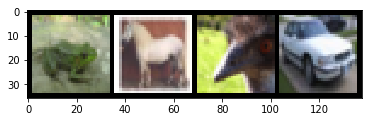

frog horse bird car


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

The `transforms` module comes also in as very handy for performing other type of data transformations: here's an example which transforms the CIFAR10 images into gray scaled images.

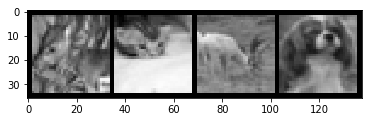

deer cat deer dog


In [6]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
gray_scaled_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
gray_scaled_trainloader = data.DataLoader(gray_scaled_trainset, batch_size=4, shuffle=True, num_workers=0)

images, labels = next(iter(gray_scaled_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.1 Transforms

Al remembered from the theoretical lectures that one way to make neural networks converge faster is to **normalize** the pixel values. He wrote the following code snippet to normalize his training set, but he encountered an error.

In [7]:
transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(), 
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=0)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

TypeError: Input tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

Fix his mistake.

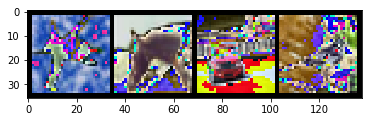

plane horse car bird


In [8]:
# your code : The arguments inside the Compose method should be in the correct order: the normalize transformation should 
# apply to a tensor and so, the ToTensor transformation needs to be executed before the normalization.

transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=0)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

Al also remembers that, with image datasets, a common practice to increase the robustness of neural networks is **data augmentation**. He wants to apply random flips (vertical and horizontal) and random color changes to his training set, but he does not know how to. Could you help him?

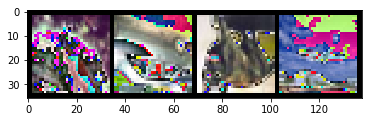

deer car cat plane
shape of 1 image =  torch.Size([3, 32, 32])
shape of the batch of images =  torch.Size([4, 3, 32, 32])
labels =  tensor([4, 1, 3, 0])
a label is the numerical value mapping a category, e.g., tensor(1)  maps  car
label = 0 	 maps to 	 plane
label = 1 	 maps to 	 car
label = 2 	 maps to 	 bird
label = 3 	 maps to 	 cat
label = 4 	 maps to 	 deer
label = 5 	 maps to 	 dog
label = 6 	 maps to 	 frog
label = 7 	 maps to 	 horse
label = 8 	 maps to 	 ship
label = 9 	 maps to 	 truck


In [9]:
# your code
transform = transforms.Compose([
    transforms.ToTensor(), transforms.RandomVerticalFlip(p=0.5), transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=0)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird ...
print(*[classes[l] for l in labels])
# our code added to check data structure of the output of the DataLoader:
print('shape of 1 image = ', images[0].shape)
print('shape of the batch of images = ', images.shape)
print('labels = ', labels)
print('a label is the numerical value mapping a category, e.g.,', labels[1], ' maps ', classes[labels[1]])
for i in range(10): # we know from the documentation of CIFAR10 that there are 10 classes...
    print('label =',i,'\t', 'maps to', '\t', classes[i])


### 1.2 Running operations on a GPU

As you may know, one important aspect of deep learning is that large models can be trained efficiently on specialized hardwares such as Graphical Processing Units (GPUs) or Tensorial Processing Units (TPUs). PyTorch allows you to perform operations on GPUs very easily by transferring the concerned models and/or tensors to GPUs.

However, to do so, you need a CUDA compatible GPU.

In [10]:
torch.cuda.is_available()

True

If the result of the previous cell is `True`, everything is ready to run on the GPU and you can continue. Otherwise it means you do not have any GPU that is compatible with the `torch` version installed on your machine. In this case, we invite you to use [Google Colab](https://colab.research.google.com/) to do the rest of this homework. Do not forget to ask Colab for a GPU (in Runtime > Change runtime type > Hardware accelerator).

In [11]:
device = 'cuda'

Let's compare the speed of tensor operations on GPU and CPU. 

In [12]:
A = torch.randn(1000, 100000)
B = torch.randn(100000, 1)

# on CPU
%timeit A @ B

13.7 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
A = torch.randn((1000, 100000), device=device)
B = torch.randn((100000, 1), device=device)

# on GPU
%timeit A @ B

2.73 ms ± 7.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Instead of directly creating a tensor on the GPU you may also transfer a model or a tensor on the GPU, for example we can transfer a simple MLP on the GPU and then back to the CPU as follows.

In [15]:
# create MLP on CPU
mlp = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

# forward pass on CPU
x = torch.randn(256, 3)
%timeit mlp(x)

# transfer MLP to GPU (in-place)
mlp.to(device)

# forward pass on GPU
x = x.to(device)
%timeit mlp(x)

# release the GPU memory
mlp.to('cpu')
x = x.to('cpu')

1.58 ms ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
225 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As you may notice, computations are much faster on the GPU. However, data transfer between GPU and CPU (and vice-versa) is usually very slow. We recommend to reduce the transfers of data between GPU and CPU as much as possible. For example when you want to save your loss after each iteration, in order to avoid a memory leak, you should prefer doing `.detach()` rather than `.cpu()` or `.item()`.

## 2.  Classifying the CIFAR10 dataset with an MLP

Now that you know how to handle datasets, we are ready to properly train today's first deep learning model on the CIFAR10 dataset. Before we dive into it, **do not underestimate** the importance of properly pre-processing the data before training neural networks. This step is as important as defining the neural architectures themselves, but is very often overlooked.

In this exercise you are provided with an already defined multi-layer perceptron that you can train to classify CIFAR10 images. The structure of the network is already defined, yet some crucial hyperparameters are missing. It is your job to fill them in and successfully train the network. As part of the exercise, you are also required to monitor the evolution of training: this usually consists in checking how the training and testing losses evolve during training and keeping track of the model's accuracy on the testing set. Report these statistics with some plots. In addition, transfer the network and the mini-batches on GPU to speed up training.

Fill in the code below, discuss your choices and your results. Are you satisfied with the final accuracy?

In [16]:
input_features = 3072 # each image is a tensor [3, 32, 32] --> 3 x 32 x 32 = 3,072 features per image (cf CIFAR10 doc) 
output_features = 10  # there are 10 classes (categories)
hidden_features = 24 # your code
learning_rate = 0.005
num_epochs = 200

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Flatten(),
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )
    
network = MLP(input_features, output_features, hidden_features)

# your code
# network is the instantiated mlp from the class MLP:
# transfer MLP to GPU, just once
device = 'cuda' # in case it was not done before
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomHorizontalFlip(p=0.5), # we could add data augmentation by shuffling horizontally and vertically ?
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]) 

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0) # num_workers = 2 was changed
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0) # num_workers = 2 was changed

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in trainloader:
            # your code
            # transfer each minibatch on the GPU:
            # forward pass on GPU
            x, y = x.to(device), y.to(device)
            
            
            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())  # ? to cpu?
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0
            
            for x, y in testloader:
                # your code
                # transfer each minibatch on the GPU:   
                x, y = x.to(device), y.to(device)
                
                pred = network(x)
                loss = criterion(pred, y)
                #test_losses.append(loss)  
                test_losses.append(loss.detach()) # ???
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

            accuracy = correct / len(testset)
            
            # accuracy.detach() # ??
            accuracy = accuracy.to('cpu')
                      
            
        # your code 
        #print('length of train losses=', len(train_losses))
        #print('length of test losses=', len(test_losses))
       
        if (i % 10 == 0 or i == num_epochs-1):
            print('iteration = ', i, '\t', 'progression =', format(i/num_epochs, '3.1%'),'\t' , 'accuracy=', accuracy)
            print('mean of train losses =', sum(train_losses)/len(train_losses),'\t', 'mean of test losses=', sum(test_losses)/len(test_losses))
        train_avg_loss.append((sum(train_losses)/len(train_losses)).item()) # we take the average loss for each minibatch in the training set
        test_avg_loss.append((sum(test_losses)/len(test_losses)).item()) # we take the average loss for each minibatch in the test set
        test_accuracy.append(accuracy)
        # release the GPU memory
        #x, y = x.to('cpu'), y.to('cpu') 
        # or ?
        #x.detach()
        #y.detach()
        

    return train_avg_loss, test_avg_loss, test_accuracy # your code

In [17]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

# release the GPU memory
#x, y = x.to('cpu'), y.to('cpu') 


iteration =  0 	 progression = 0.0% 	 accuracy= tensor(0.4145)
mean of train losses = tensor(1.7673, device='cuda:0') 	 mean of test losses= tensor(1.6439, device='cuda:0')
iteration =  10 	 progression = 5.0% 	 accuracy= tensor(0.4705)
mean of train losses = tensor(1.4376, device='cuda:0') 	 mean of test losses= tensor(1.4974, device='cuda:0')
iteration =  20 	 progression = 10.0% 	 accuracy= tensor(0.4799)
mean of train losses = tensor(1.3911, device='cuda:0') 	 mean of test losses= tensor(1.4825, device='cuda:0')
iteration =  30 	 progression = 15.0% 	 accuracy= tensor(0.4848)
mean of train losses = tensor(1.3689, device='cuda:0') 	 mean of test losses= tensor(1.4643, device='cuda:0')
iteration =  40 	 progression = 20.0% 	 accuracy= tensor(0.4792)
mean of train losses = tensor(1.3433, device='cuda:0') 	 mean of test losses= tensor(1.4904, device='cuda:0')
iteration =  50 	 progression = 25.0% 	 accuracy= tensor(0.4737)
mean of train losses = tensor(1.3350, device='cuda:0') 	 mean o

Plot the statistics below and discuss your hyperparameter choices.

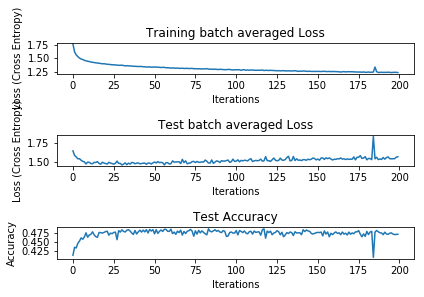

In [18]:
# your code

fig, axs = plt.subplots(3, 1)

axs[0].set_title('Training batch averaged Loss')
axs[0].plot(train_avg_loss)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss (Cross Entropy)')

axs[1].set_title('Test batch averaged Loss')
axs[1].plot(test_avg_loss)
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss (Cross Entropy)')

axs[2].set_title('Test Accuracy')
axs[2].plot(test_accuracy)
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

> your discussion

Even though the training loss decreases during the training process, the accuracy on the test set always keeps around 0.50, meaning that the classification is wrong in half of the cases. The fully connected neural network perfoms poorly in image classification. We changed the width of the hidden_features, it didn't improve the accuracy. We changed the learning rate, it did't improve either. Number of iterations ? The program running time is rather long on our platform (laptop with a single GPU NVIDIA Quadro P3200 0.71-1.13 GHz, 192 bit@7008 MHz): +/- 1 hour for 200 iterations.

## 3.  Create a custom dataset

Sometimes you would like to train a model on your own dataset, which will very likely not be part of `torchvision`. To overcome this you can create a custom dataset class which will handle the data for you. This can be done by inheriting from `torch`'s `data.Dataset` class and defining the methods `__len__` and `__getitem__` (see the [documentation](https://pytorch.org/docs/stable/data.htm)).

In this exercise your goal is to program a custom dataset class which you will later use for training a CNN. We will use the Kaggle Cats and Dogs dataset which you can download from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). 

When programming a custom dataset class, you have to start by defining the constructor, which will get as input the location of your dataset, whether the images that will be returned will serve for training or testing, and some other potential attributes. For this exercise we will be using 20000 images for training and 5000 images for testing. For the `__getitem__` function you may find the `PIL.Image.open` useful. Do not forget to transform the images into tensors and return the image labels as well ($0$ or $1$).

In [19]:
# your code
# Create the target (labels) file for cats and dogs:
# in the 'PetImages' library, there are 25,000 images of cats and dogs, 12,500 images in each category.
# we will assign target (label) y value = 0 for cats and 1 for dogs (binary outcome).
# Pay attention that the images are loaded in the correct order: cats first and dogs last !
# You may need to remove the two 'thumb.db' files which are in the 'cats' and 'dogs' subdirectory respectively.
# You may have to conduct a sanitary check...We found that one of the dog picture was actually empty (dog image #11702).
# We replaced this empty image by the previous one (duplicated).

root_dir = r"C:/Users/marcjoiret/Desktop/MARC\TISSUE ENGINEERING and REGENERATIVE MEDICINE/DEEP LEARNING/Homework/PetImages/CatsAndDogs/"
target_file = r"targets.txt"
created_target_file = open(root_dir+target_file, 'w')
for pet in range(25000):
    line = format(pet, '5d') + '\t' + format(int(pet > 12499), '1d') + '\n'
    created_target_file.write(line)
created_target_file.close()

import pandas as pd

from torch.utils.data import Dataset

class CatAndDogsDataset(data.Dataset):
    def __init__(self, root_dir, target_file, train=True, transform = None):
        """Initializes a dataset containing images and labels."""
        super(CatAndDogsDataset, self).__init__()
        # your code
        #df = pd.read_table(root_dir+target_file)
        self.root_dir = root_dir
        #self.target_file = target_file
        self.labels = pd.read_table(root_dir+target_file, header=None)
        self.train = train
        self.transform = transform
    
    def __len__(self):
        """returns size of datatset."""
        return len(self.labels)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        ''' and returns the target label.'''
        # your code
        #super().__getitem__(index)
        img = Image.open(root_dir+str(index)+'.jpg')
        if self.transform:
            img = self.transform(img)
        y_label = torch.tensor(int(self.labels.iloc[index, 1]))
        return img, y_label
            

Let us have a quick look at these samples.

labels
           0  1
0          0  0
1          1  0
2          2  0
3          3  0
4          4  0
...      ... ..
24995  24995  1
24996  24996  1
24997  24997  1
24998  24998  1
24999  24999  1

[25000 rows x 2 columns]
length of my_dataset =  25000
index =  12500 , the target for this index =  1


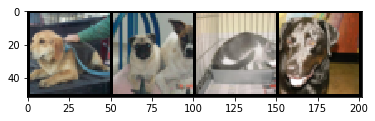

dog dog cat dog


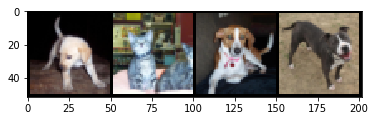

dog cat dog dog
images shape= torch.Size([4, 3, 48, 48])


In [48]:
#my_dataset = CatAndDogsDataset('kagglecatsanddogs_3367a/PetImages/', train=True)
#my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=0)

# your code
root_dir = r"C:/Users/marcjoiret/Desktop/MARC\TISSUE ENGINEERING and REGENERATIVE MEDICINE/DEEP LEARNING/Homework/PetImages/CatsAndDogs/"
target_file = r"targets.txt"

# note that the images do not all have the same size...So, we want to rescale them to the same size:
scale_transform = transforms.Compose([
    transforms.Resize(48),
    transforms.RandomCrop(48), # transforms.RandomCrop(512), transforms.CenterCrop(512),
    #transforms.RandomVerticalFlip(p=0.5), transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

my_dataset = CatAndDogsDataset(root_dir, target_file, train=True, transform = scale_transform)
# print the labels:
print('labels')
print(my_dataset.labels)
# print the length of the cats and dogs dataset:
print('length of my_dataset = ', my_dataset.__len__())
# return the image and its label for a given index:
idx = 12500
image, targetlabel = my_dataset.__getitem__(idx)
print('index = ', idx, ', the target for this index = ', targetlabel.item())

train_set, test_set = torch.utils.data.random_split(my_dataset, [20000, 5000])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True, num_workers=0)

classes = ['cat', 'dog']

images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))  
print(*[classes[l] for l in labels])
      
images, labels = next(iter(test_loader))
show_images(utils.make_grid(images))  
print(*[classes[l] for l in labels])

print('images shape=', images.shape)


## 4. Classifying the Cats and Dogs dataset with a CNN

As we have seen in class, classifying images with a multi-layer perceptron isn't really a good idea. Convolutional Neural Networks (CNN) are in fact a much better option for this task. It is now your job to create your custom CNN and train it on the Cats and Dogs Dataset.

Similarly to what you have done when classifying the CIFAR10 dataset you are again required to report and discuss the performance of your model.

iteration =  0 	 progression = 0.0% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6936, device='cuda:0') 	 mean of test losses= tensor(0.6937, device='cuda:0')
iteration =  5 	 progression = 14.3% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6939, device='cuda:0') 	 mean of test losses= tensor(0.6939, device='cuda:0')
iteration =  10 	 progression = 28.6% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6938, device='cuda:0') 	 mean of test losses= tensor(0.6939, device='cuda:0')
iteration =  15 	 progression = 42.9% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6940, device='cuda:0') 	 mean of test losses= tensor(0.6948, device='cuda:0')
iteration =  20 	 progression = 57.1% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6938, device='cuda:0') 	 mean of test losses= tensor(0.6931, device='cuda:0')
iteration =  25 	 progression = 71.4% 	 accuracy= tensor(0.0002)
mean of train losses = tensor(0.6937, device='cuda:0') 	 mean o

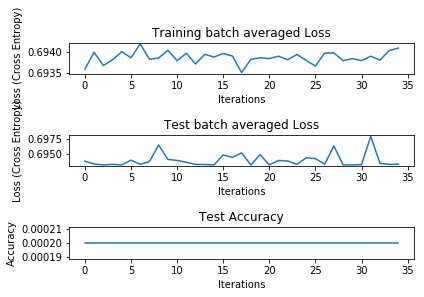

In [54]:
# your code

# DATA PREPROCESSING (cleaning was previously taken care of)
#-----------------------------------------------------------
# Note that the original raw images do not all have the same size...So, we want to rescale them to the same size.
# We also applied data-augmentation by flipping both vertically and horizontally the pixels.
# We normalized as well:
scale_transform = transforms.Compose([
    transforms.Resize(48),
    transforms.RandomCrop(48), # transforms.RandomCrop(512) or transforms.CenterCrop(512),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

my_dataset = CatAndDogsDataset(root_dir, target_file, train=True, transform = scale_transform)
classes = ['cat', 'dog']

#input_features = 6,912, each image is a tensor [3, 48, 48] --> 3 x 48 x 48 = 6,912 features per image (cf previous snippet) 
#output_features = 2, there are 2 classes (categories): a cat (0) or a dog (1)
#hidden_features: see CNN architecture below, hidden features depend on the layer and on the pooling layers...

learning_rate = 0.01
num_epochs = 35  # between 35 and 200 or more...

# implement the CNN architecture of our own design:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 9)  # (input channel size, output channel size, kernel size)
        self.pool1 = nn.MaxPool2d(2, 2) # (kernel size, stride size) 
        self.conv2 = nn.Conv2d(16, 16, 5) # (here: input = output of conv1)
        self.pool2 = nn.MaxPool2d(2, 2) # (kernel size, stride size) 
        # (W-F+2P)/S + 1 = (48-9+0)/1 + 1 = 40 pooled by 2=20, (20-5)/1+1=16 pooled by 2=8
        self.fc1 = nn.Linear(16*8*8, 24) 
        self.fc2 = nn.Linear(24, 2) # last output must be 2 classes (binary classification)
        #self.fc3 = nn.Linear(24, 2) # last output must be 2 classes (binary classification)
        self.fc3 = nn.Linear(2, 1) # to prepare for sigmoid activation function to get a probability
        
        # INITIALIZE THE WEIGHTS:
        self.initialize_weights()
        
    def forward(self, x):
        #x = activFun.ReLU(self.conv1(x))
        x = self.pool1(F.relu(self.conv1(x))) # first convolutional layer
        x = self.pool2(F.relu(self.conv2(x))) # 2nd convolutional layer
        #x = x.view(-1, 16*8*8) # tensor flattened to enter the fully connected layer
        x = x.view(x.shape[0], -1) # tensor flattened to enter the fully connected layer
        x = F.relu(self.fc1(x)) # first fully connected layer
        x = F.relu(self.fc2(x)) # --> 2 outputs (second fully connected layer)
        #x = F.relu(self.fc3(x)) # --> 2 outputs
        x = torch.sigmoid(self.fc3(x)) # --> 1 output (probability between 0 and 1) to be a dog.
        #x = nn.Sigmoid(self.fc4(x)) # --> 1 output (probability between 0 and 1) to be a dog.
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                nn.init.constant_(m.bias, 0)
        
# create (instantiate) our model
our_cnn = CNN()

# Use GPU if possible (move the model on the GPU)
our_cnn.to(device)

# criterion/LOSS: binary cross entropy loss function as we are doing binary classification
criterion = nn.BCELoss()  # or could be BCEWithLogitsLoss(), see pytorch doc.

# Optimizer: Adam or SGD or...
optimizer = torch.optim.Adam(our_cnn.parameters(), lr=learning_rate)

# data loader:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=3, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=3, shuffle=False, num_workers=0)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in train_loader:
            # Move the training data on the GPU:
            # transfer each minibatch on the GPU:
            x, y = x.to(device), y.to(device)
            
            # forward pass on GPU:
            pred = our_cnn(x)
            loss = criterion(pred.squeeze(1), y.float())
            train_losses.append(loss.detach())  # better than to cpu
            
            # backward and optimize:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0
            
            for x, y in test_loader:
                # your code
                # transfer each minibatch on the GPU:   
                x, y = x.to(device), y.to(device)
                
                pred = our_cnn(x)
                loss = criterion(pred.squeeze(1), y.float())
                #test_losses.append(loss)  
                test_losses.append(loss.detach()) 
                
                #y_pred = pred.argmax(dim=-1)
                #correct = correct + (y_pred == y).sum()
                
                y_pred_class = (pred.squeeze(1) > 0.5).int() # we assign a label (0 or 1) based on our_cnn's prediction (1 is a dog)
                correct = (y == y_pred_class).float().sum()  # compute number of correct predictions
                #print('y=', y)
                #print('y_pred_class=', y_pred_class)
                #print('correct matches=', correct)
                
            accuracy = correct / len(test_set)
            accuracy = accuracy.to('cpu')
            
        # print information on the training progress and performances: 
       
        if (i % 5 == 0 or i == num_epochs-1):
            print('iteration = ', i, '\t', 'progression =', format(i/num_epochs, '3.1%'),'\t' , 'accuracy=', accuracy)
            print('mean of train losses =', sum(train_losses)/len(train_losses),'\t', 'mean of test losses=', sum(test_losses)/len(test_losses))
        train_avg_loss.append((sum(train_losses)/len(train_losses)).item()) # we take the average loss for each minibatch in the training set
        test_avg_loss.append((sum(test_losses)/len(test_losses)).item()) # we take the average loss for each minibatch in the test set
        test_accuracy.append(accuracy)      

    return train_avg_loss, test_avg_loss, test_accuracy

train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

# plot the loss scoring and accuracy:
fig, axs = plt.subplots(3, 1)

axs[0].set_title('Training batch averaged Loss')
axs[0].plot(train_avg_loss)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss (Cross Entropy)')

axs[1].set_title('Test batch averaged Loss')
axs[1].plot(test_avg_loss)
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss (Cross Entropy)')

axs[2].set_title('Test Accuracy')
axs[2].plot(test_accuracy)
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


> your discussion

The CNN performs much better in images classification than the NN. 

One of the first hyperparameter to optimize is the learning rate. We started with lr = 0.001 and changed it to lr = 0.01.

We opted for a BCE loss, because we are doing binary classification.

In the design of our CNN, 2 conv layers and 2 pooling layers are alternated. This is meant to improve the performance: both speed (pooling reduces the computation load).

We also showed that the test accuracy was better upon horizontal and/or vertical pixel flipping the images as a data pre-processing step. Of course in addition to the image resize + normalization. Do not resize too large (32 x 32 or 48 x 48).

## Feedback

Now that you are done with this final deep-learning assignment here are some final questions about the exercises you were required to solve:

<span style="color:blue">How much time did you spend on this homework?</span>

Marc spent 3 x 4 hours. The custom dataset and dataloader took me 2/3 of time.

<span style="color:blue">Do you feel confortable with what it means to define a neural network and train it?</span>

Yes.

<span style="color:blue">Do you think you now have enough preliminary knowledge for successfully starting to work on your course final project?</span>

Yes.

<span style="color:blue">If you had to go through the two homeworks again, is there something you would have liked to explore more or explained more into detail?</span>

I don't see in which situations you would need a large number of layers in neural networks ? According to the experience and practice on the two homeworks, it seems shallower neural networks perform quite good. So, why and when would you need deeper layers ?